In [15]:
import pandas as pd
from datetime import time, datetime, timedelta
import numpy as np
# plotting the link time period KPIs for the first link
import matplotlib.pyplot as plt

# loading the static data
calendarDates = pd.read_csv('static/calendar_dates.csv')
routes = pd.read_csv('static/routes.csv')
shapes = pd.read_csv('static/shapes.csv')
stopTimes = pd.read_csv('static/stop_times.csv')
stops = pd.read_csv('static/stops.csv')
trips = pd.read_csv('static/trips.csv')

In [16]:
# Function to convert times with hours > 24 to timedelta
def convert_gtfs_time_to_timedelta(time_str):
	hours, minutes, seconds = map(int, time_str.split(':'))
	return timedelta(hours=hours, minutes=minutes, seconds=seconds)

# Converting arrival and departure times to timedeltas
stopTimes['arrival_time'] = stopTimes['arrival_time'].apply(convert_gtfs_time_to_timedelta)
stopTimes['departure_time'] = stopTimes['departure_time'].apply(convert_gtfs_time_to_timedelta)

# Dwell time calculation (in seconds)
stopTimes['dwell_time'] = (stopTimes['departure_time'] - stopTimes['arrival_time']).dt.total_seconds()

stopTimes.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled,dwell_time
0,6801326_20121,0 days 07:00:00,0 days 07:00:00,PF_A15_C,1,0,0,0.0000,0.0
1,6801326_20121,0 days 07:04:00,0 days 07:04:00,PF_A14_C,2,0,0,2.6710,0.0
2,6801326_20121,0 days 07:07:00,0 days 07:07:00,PF_A13_C,3,0,0,4.7758,0.0
3,6801326_20121,0 days 07:09:00,0 days 07:09:00,PF_A12_C,4,0,0,5.8746,0.0
4,6801326_20121,0 days 07:12:00,0 days 07:12:00,PF_A11_C,5,0,0,7.3282,0.0


In [17]:
# Create time periods spanning from 00:01 to 24:00 (midnight) in 15-minute intervals
time_periods = []
time_period_labels = []

# Starting with 00:01 to avoid the ambiguous 00:00 that could be either start or end of day
start_time = datetime.combine(datetime.today().date(), time(0, 1))

for i in range(96):  # 24 hours × 4 quarters = 96 time periods
    time_point = start_time + timedelta(minutes=15*i)
    time_periods.append(time_point.time())
    
    # Create a formatted time label (e.g., "00:01", "00:16")
    time_period_labels.append(time_point.strftime('%H:%M'))

# Create a dictionary mapping index to time periods
time_period_dict = dict(zip(range(len(time_periods)), time_periods))

# Create a dictionary with formatted time labels for display purposes
time_period_label_dict = dict(zip(range(len(time_period_labels)), time_period_labels))

# Preview the time periods
pd.DataFrame({'Time Period ID': list(time_period_dict.keys()), 
              'Time': [t.strftime('%H:%M') for t in time_period_dict.values()]})

,Time Period ID,Time
0,0,00:01
1,1,00:16
2,2,00:31
3,3,00:46
4,4,01:01
...,...,...
91,91,22:46
92,92,23:01
93,93,23:16
94,94,23:31


In [18]:
# mapping the time periods and time period ids to the stop times
# Convert timedelta to total seconds, then calculate the time period ID
# Each day has 24*60*60 = 86400 seconds
# Each 15-minute period has 15*60 = 900 seconds
stopTimes['total_seconds'] = stopTimes['arrival_time'].dt.total_seconds()
# Calculate hours and minutes from seconds
stopTimes['hour'] = (stopTimes['total_seconds'] / 3600).astype(int) % 24  # mod 24 to handle times > 24 hours
stopTimes['minute'] = ((stopTimes['total_seconds'] % 3600) / 60).astype(int)
stopTimes['time_period_id'] = stopTimes['hour'] * 4 + stopTimes['minute'] // 15
stopTimes['time_period'] = stopTimes['time_period_id'].map(time_period_dict)
stopTimes['time_period_label'] = stopTimes['time_period_id'].map(time_period_label_dict)

# Drop temporary columns
stopTimes = stopTimes.drop(['total_seconds', 'hour', 'minute'], axis=1)

stopTimes

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled,dwell_time,time_period_id,time_period,time_period_label
0,6801326_20121,0 days 07:00:00,0 days 07:00:00,PF_A15_C,1,0,0,0.0000,0.0,28,07:01:00,07:01
1,6801326_20121,0 days 07:04:00,0 days 07:04:00,PF_A14_C,2,0,0,2.6710,0.0,28,07:01:00,07:01
2,6801326_20121,0 days 07:07:00,0 days 07:07:00,PF_A13_C,3,0,0,4.7758,0.0,28,07:01:00,07:01
3,6801326_20121,0 days 07:09:00,0 days 07:09:00,PF_A12_C,4,0,0,5.8746,0.0,28,07:01:00,07:01
4,6801326_20121,0 days 07:12:00,0 days 07:12:00,PF_A11_C,5,0,0,7.3282,0.0,28,07:01:00,07:01
...,...,...,...,...,...,...,...,...,...,...,...,...
192467,6556673_20121,1 days 00:24:00,1 days 00:24:00,PF_G01_C,30,0,0,38.3862,0.0,1,00:16:00,00:16
192468,6556673_20121,1 days 00:27:00,1 days 00:27:00,PF_G02_C,31,0,0,39.7328,0.0,1,00:16:00,00:16
192469,6556673_20121,1 days 00:29:00,1 days 00:29:00,PF_G03_C,32,0,0,40.7174,0.0,1,00:16:00,00:16
192470,6556673_20121,1 days 00:32:00,1 days 00:32:00,PF_G04_C,33,0,0,42.4462,0.0,2,00:31:00,00:31


In [19]:
# generating the link information and saving it to a csv file
links = []
for i in range(len(stopTimes) - 1):
    if stopTimes.loc[i, 'trip_id'] == stopTimes.loc[i + 1, 'trip_id']:
        start_stop = stopTimes.loc[i, 'stop_id']
        end_stop = stopTimes.loc[i + 1, 'stop_id']
        start_sequence = stopTimes.loc[i, 'stop_sequence']
        end_sequence = stopTimes.loc[i + 1, 'stop_sequence']
        length = stopTimes.loc[i + 1, 'shape_dist_traveled'] - stopTimes.loc[i, 'shape_dist_traveled']

        # Calculate time difference in minutes
        start_time = stopTimes.loc[i, 'departure_time']
        end_time = stopTimes.loc[i + 1, 'arrival_time']
        scheduled_time_taken = (end_time - start_time).total_seconds() / 60
        
        # Get time period information
        start_time_period_id = stopTimes.loc[i, 'time_period_id']
        end_time_period_id = stopTimes.loc[i + 1, 'time_period_id']
        
        # Include links where either arrival or departure falls within the same time period
        # or when they span the same time period
        if start_time_period_id == end_time_period_id:
            # Same time period
            time_period_id = start_time_period_id
            time_period = stopTimes.loc[i, 'time_period']
            time_period_label = stopTimes.loc[i, 'time_period_label']
            
            links.append({
                'trip_id': stopTimes.loc[i, 'trip_id'],
                'start_stop': start_stop,
                'end_stop': end_stop,
                'start_sequence': start_sequence,
                'end_sequence': end_sequence,
                'length': length,
                'scheduled_time_taken [mins]': scheduled_time_taken,
                'expected_speed [km/h]': length / (scheduled_time_taken / 60),
                'start_time': start_time,
                'end_time': end_time,
                'time_period_id': time_period_id,
                'time_period': time_period,
                'time_period_label': time_period_label
            })
        else:
            # Add based on departure time period
            time_period_id = start_time_period_id
            time_period = stopTimes.loc[i, 'time_period']
            time_period_label = stopTimes.loc[i, 'time_period_label']
            
            links.append({
                'trip_id': stopTimes.loc[i, 'trip_id'],
                'start_stop': start_stop,
                'end_stop': end_stop,
                'start_sequence': start_sequence,
                'end_sequence': end_sequence,
                'length': length,
                'scheduled_time_taken [mins]': scheduled_time_taken,
                'expected_speed [km/h]': length / (scheduled_time_taken / 60),
                'start_time': start_time,
                'end_time': end_time,
                'time_period_id': time_period_id,
                'time_period': time_period,
                'time_period_label': time_period_label,
                'time_period_type': 'departure'
            })
            
            # Add based on arrival time period
            time_period_id = end_time_period_id
            time_period = stopTimes.loc[i+1, 'time_period']
            time_period_label = stopTimes.loc[i+1, 'time_period_label']
            
            links.append({
                'trip_id': stopTimes.loc[i, 'trip_id'],
                'start_stop': start_stop,
                'end_stop': end_stop,
                'start_sequence': start_sequence,
                'end_sequence': end_sequence,
                'length': length,
                'scheduled_time_taken [mins]': scheduled_time_taken,
                'expected_speed [km/h]': length / (scheduled_time_taken / 60),
                'start_time': start_time,
                'end_time': end_time,
                'time_period_id': time_period_id,
                'time_period': time_period,
                'time_period_label': time_period_label,
                'time_period_type': 'arrival'
            })

linksDf = pd.DataFrame(links)

# Add time_period_type column for consistent schema if it doesn't exist in some rows
if 'time_period_type' not in linksDf.columns:
    linksDf['time_period_type'] = 'same'
else:
    # Fill missing values with 'same' for links that were in the same time period
    linksDf['time_period_type'] = linksDf['time_period_type'].fillna('same')

linksDf.to_csv('static/links.csv', index=False)
linksDf

,trip_id,start_stop,end_stop,start_sequence,end_sequence,length,scheduled_time_taken [mins],expected_speed [km/h],start_time,end_time,time_period_id,time_period,time_period_label,time_period_type
0,6801326_20121,PF_A15_C,PF_A14_C,1,2,2.6710,4.0,40.065,0 days 07:00:00,0 days 07:04:00,28,07:01:00,07:01,same
1,6801326_20121,PF_A14_C,PF_A13_C,2,3,2.1048,3.0,42.096,0 days 07:04:00,0 days 07:07:00,28,07:01:00,07:01,same
2,6801326_20121,PF_A13_C,PF_A12_C,3,4,1.0988,2.0,32.964,0 days 07:07:00,0 days 07:09:00,28,07:01:00,07:01,same
3,6801326_20121,PF_A12_C,PF_A11_C,4,5,1.4536,3.0,29.072,0 days 07:09:00,0 days 07:12:00,28,07:01:00,07:01,same
4,6801326_20121,PF_A11_C,PF_A10_C,5,6,2.1612,4.0,32.418,0 days 07:12:00,0 days 07:16:00,28,07:01:00,07:01,departure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214936,6556673_20121,PF_G01_C,PF_G02_C,30,31,1.3466,3.0,26.932,1 days 00:24:00,1 days 00:27:00,1,00:16:00,00:16,same
214937,6556673_20121,PF_G02_C,PF_G03_C,31,32,0.9846,2.0,29.538,1 days 00:27:00,1 days 00:29:00,1,00:16:00,00:16,same
214938,6556673_20121,PF_G03_C,PF_G04_C,32,33,1.7288,3.0,34.576,1 days 00:29:00,1 days 00:32:00,1,00:16:00,00:16,departure
214939,6556673_20121,PF_G03_C,PF_G04_C,32,33,1.7288,3.0,34.576,1 days 00:29:00,1 days 00:32:00,2,00:31:00,00:31,arrival


In [20]:
# filtering the unique links
uniqueLinks = linksDf.drop_duplicates(subset=['start_stop', 'end_stop'])[['start_stop', 'end_stop','start_sequence', 'end_sequence', 'length']]
uniqueLinks.reset_index(drop=True, inplace=True)
uniqueLinks

,start_stop,end_stop,start_sequence,end_sequence,length
0,PF_A15_C,PF_A14_C,1,2,2.6710
1,PF_A14_C,PF_A13_C,2,3,2.1048
2,PF_A13_C,PF_A12_C,3,4,1.0988
3,PF_A12_C,PF_A11_C,4,5,1.4536
4,PF_A11_C,PF_A10_C,5,6,2.1612
...,...,...,...,...,...
197,PF_N11_C,PF_N10_C,2,3,2.8733
198,PF_N10_C,PF_N09_C,3,4,2.0799
199,PF_N09_C,PF_N08_C,4,5,1.7224
200,PF_N08_C,PF_N07_C,5,6,1.3477


In [21]:
# unique nodes and average dwell time
uniqueNodes = stopTimes.drop_duplicates(subset=['stop_id'])[['stop_id']]
uniqueNodes.reset_index(drop=True, inplace=True)
uniqueNodes['average_dwell_time [mins]'] = stopTimes.groupby('stop_id')['dwell_time'].mean() / 60
uniqueNodes

,stop_id,average_dwell_time [mins]
0,PF_A15_C,NaN
1,PF_A14_C,NaN
2,PF_A13_C,NaN
3,PF_A12_C,NaN
4,PF_A11_C,NaN
...,...,...
120,PF_N08_C,NaN
121,PF_N09_C,NaN
122,PF_N10_C,NaN
123,PF_N11_C,NaN


In [22]:
# Creating a new dataframe to store the KPIs for each link in each time period
link_time_period_kpis = []

# Iterate over unique links
for index, row in uniqueLinks.iterrows():
    # Get all trips for this link
    link = linksDf[(linksDf['start_stop'] == row['start_stop']) & (linksDf['end_stop'] == row['end_stop'])]
    
    # Get all unique time periods for this link
    unique_time_periods = link['time_period_id'].unique()
    
    # For each time period, calculate the KPIs
    for time_period_id in unique_time_periods:
        # Get link data for this time period
        link_time_period = link[link['time_period_id'] == time_period_id]
        
        # If there are no trips in this time period, skip
        if len(link_time_period) == 0:
            continue
        
        # Calculate speed metrics - only mean
        mean_speed = link_time_period['expected_speed [km/h]'].mean()
        
        # Calculate time metrics - only mean
        mean_time = link_time_period['scheduled_time_taken [mins]'].mean()
        
        # Calculate headway metrics - only mean
        trips_at_end_stop = stopTimes[(stopTimes['stop_id'] == row['end_stop']) & 
                                      (stopTimes['stop_sequence'] == row['end_sequence']) & 
                                      (stopTimes['time_period_id'] == time_period_id)].copy()
                                      
        trips_at_end_stop = trips_at_end_stop.sort_values(by='departure_time')
        headways = trips_at_end_stop['departure_time'].diff().dt.total_seconds().dropna().abs() / 60
        
        # Remove headways that are 0 (same departure time)
        headways = headways[headways > 0]
        
        # Calculate mean headway if there are valid headways
        mean_headway = headways.mean() if not headways.empty else None
        
        # Get time period info
        time_period = time_period_dict.get(time_period_id)
        time_period_label = time_period_label_dict.get(time_period_id)
        
        # Add to results
        link_time_period_kpis.append({
            'start_stop': row['start_stop'],
            'end_stop': row['end_stop'],
            'start_sequence': row['start_sequence'],
            'end_sequence': row['end_sequence'],
            'length': row['length'],
            'time_period_id': time_period_id,
            'time_period': time_period,
            'time_period_label': time_period_label,
            'mean_speed [km/h]': mean_speed,
            'mean_time [mins]': mean_time,
            'mean_headway [mins]': mean_headway,
            'trip_count': len(link_time_period)
        })

# Convert to DataFrame
link_time_period_kpis_df = pd.DataFrame(link_time_period_kpis)

# Display some sample data
link_time_period_kpis_df.head()


,start_stop,end_stop,start_sequence,end_sequence,length,time_period_id,time_period,time_period_label,mean_speed [km/h],mean_time [mins],mean_headway [mins],trip_count
0,PF_A15_C,PF_A14_C,1,2,2.671,28,07:01:00,07:01,40.065,4.0,3.333333,16
1,PF_A15_C,PF_A14_C,1,2,2.671,29,07:16:00,07:16,40.065,4.0,2.166667,16
2,PF_A15_C,PF_A14_C,1,2,2.671,30,07:31:00,07:31,40.065,4.0,2.500000,16
3,PF_A15_C,PF_A14_C,1,2,2.671,31,07:46:00,07:46,40.065,4.0,2.166667,16
4,PF_A15_C,PF_A14_C,1,2,2.671,32,08:01:00,08:01,40.065,4.0,2.500000,16


In [23]:
trips_at_end_stop

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,shape_dist_traveled,dwell_time,time_period_id,time_period,time_period_label
184529,6561574_20121,1 days 00:23:00,1 days 00:23:00,PF_N06_C,7,0,0,11.1386,0.0,1,00:16:00,00:16
186529,6838206_20121,1 days 00:23:00,1 days 00:23:00,PF_N06_C,7,0,0,11.1386,0.0,1,00:16:00,00:16
191888,6559558_20121,1 days 00:23:00,1 days 00:23:00,PF_N06_C,7,0,0,11.1386,0.0,1,00:16:00,00:16


In [24]:
# Save the time period specific KPIs
link_time_period_kpis_df.to_csv('revised-outputs/revised_static_kpis.csv', index=False)

In [25]:
uniqueLinks.to_csv('revised-outputs/revised_unique_links.csv', index=False)
uniqueLinks

,start_stop,end_stop,start_sequence,end_sequence,length
0,PF_A15_C,PF_A14_C,1,2,2.6710
1,PF_A14_C,PF_A13_C,2,3,2.1048
2,PF_A13_C,PF_A12_C,3,4,1.0988
3,PF_A12_C,PF_A11_C,4,5,1.4536
4,PF_A11_C,PF_A10_C,5,6,2.1612
...,...,...,...,...,...
197,PF_N11_C,PF_N10_C,2,3,2.8733
198,PF_N10_C,PF_N09_C,3,4,2.0799
199,PF_N09_C,PF_N08_C,4,5,1.7224
200,PF_N08_C,PF_N07_C,5,6,1.3477


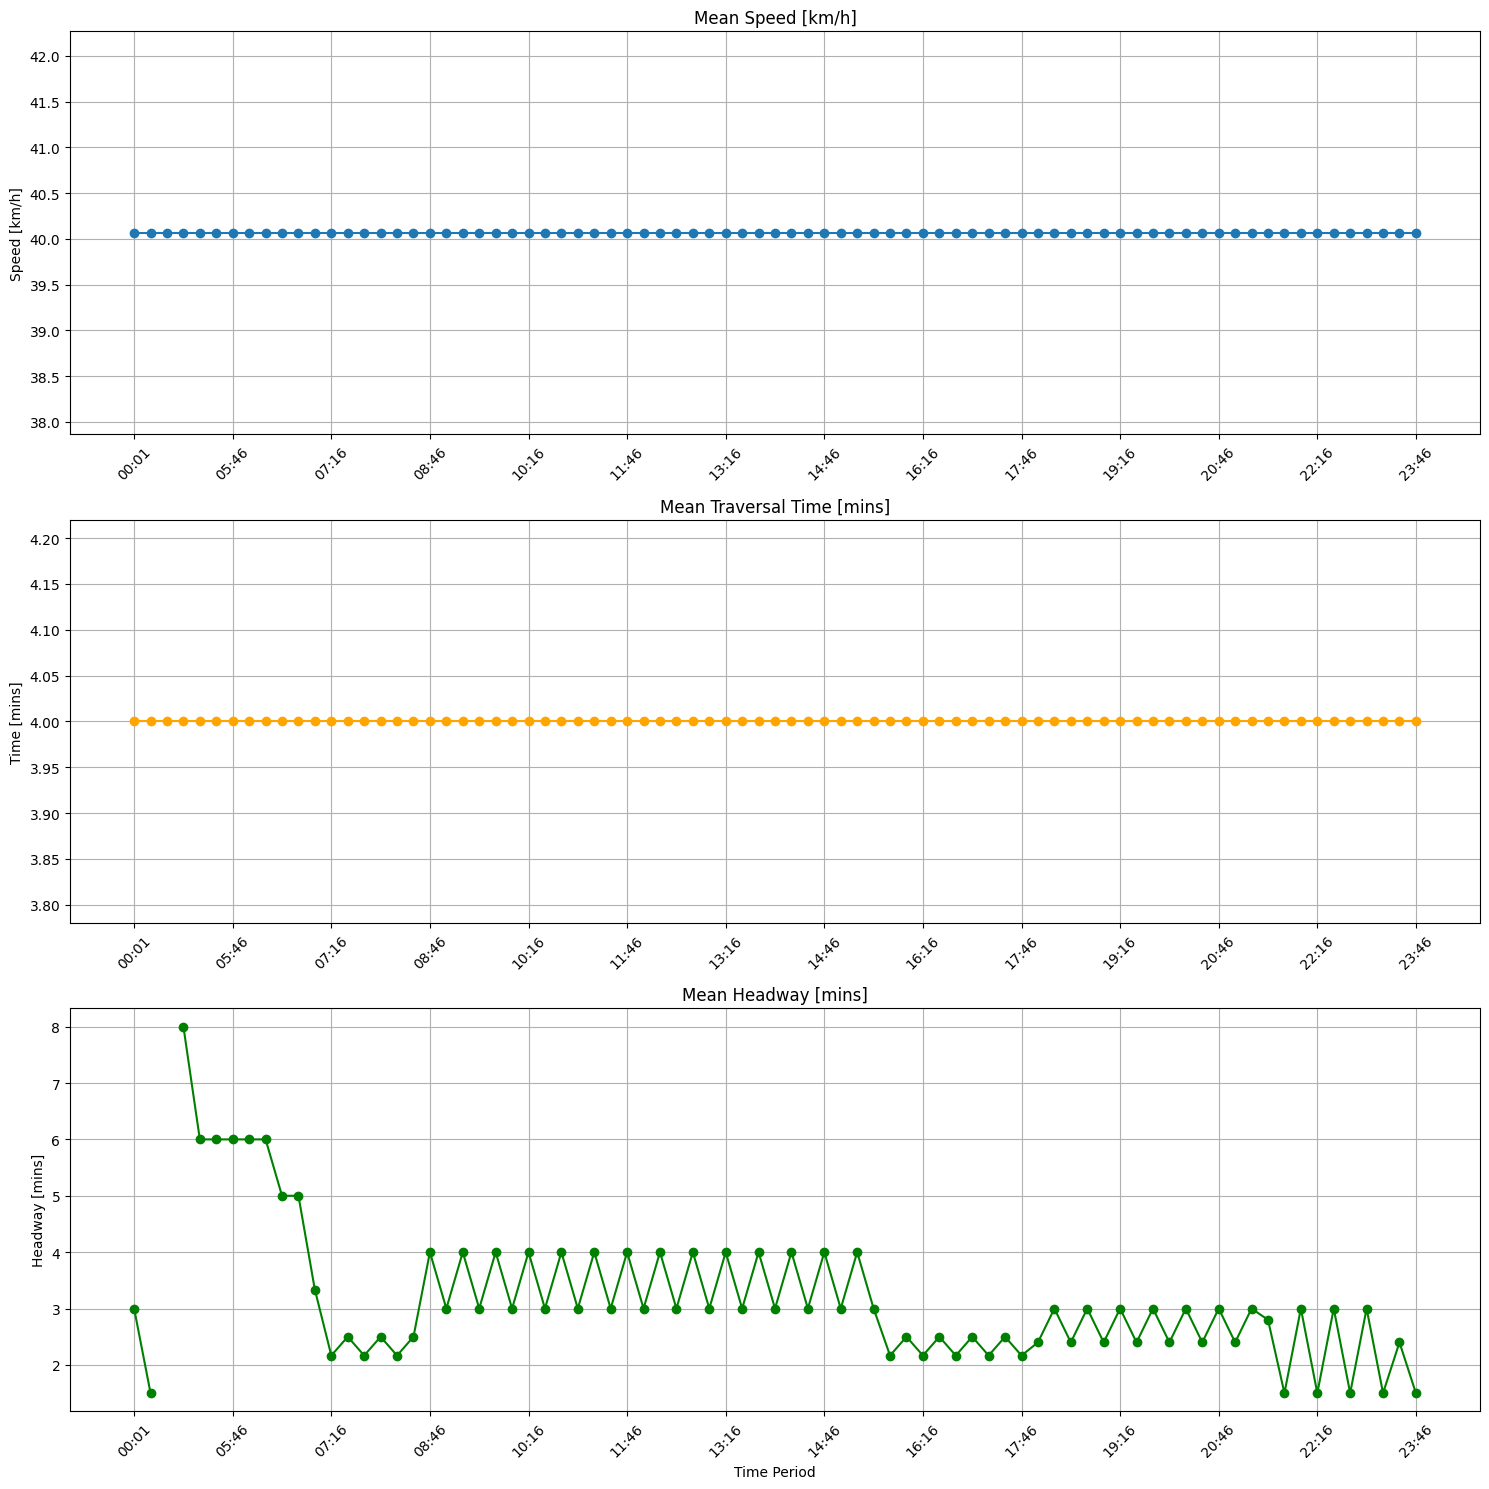

In [31]:
# Filter data for the first link
first_link = link_time_period_kpis_df[(link_time_period_kpis_df['start_stop'] == uniqueLinks.loc[0, 'start_stop']) & 
                                      (link_time_period_kpis_df['end_stop'] == uniqueLinks.loc[0, 'end_stop'])]

# Sort by time_period_id for chronological display
first_link = first_link.sort_values('time_period_id')

# Plot the KPIs
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# Speed
ax[0].plot(first_link['time_period_label'], first_link['mean_speed [km/h]'], marker='o')
ax[0].set_title('Mean Speed [km/h]')
ax[0].set_ylabel('Speed [km/h]')
ax[0].grid(True)

# Only show a subset of x-labels to avoid crowding
x_ticks = range(0, len(first_link), max(1, len(first_link)//12))
x_labels = [first_link['time_period_label'].iloc[i] for i in x_ticks]
ax[0].set_xticks([first_link['time_period_label'].iloc[i] for i in x_ticks])
ax[0].set_xticklabels(x_labels, rotation=45)

# Time
ax[1].plot(first_link['time_period_label'], first_link['mean_time [mins]'], marker='o', color='orange')
ax[1].set_title('Mean Traversal Time [mins]')
ax[1].set_ylabel('Time [mins]')
ax[1].grid(True)
ax[1].set_xticks([first_link['time_period_label'].iloc[i] for i in x_ticks])
ax[1].set_xticklabels(x_labels, rotation=45)

# Headway
ax[2].plot(first_link['time_period_label'], first_link['mean_headway [mins]'], marker='o', color='green')
ax[2].set_title('Mean Headway [mins]')
ax[2].set_xlabel('Time Period')
ax[2].set_ylabel('Headway [mins]')
ax[2].grid(True)
ax[2].set_xticks([first_link['time_period_label'].iloc[i] for i in x_ticks])
ax[2].set_xticklabels(x_labels, rotation=45)

plt.tight_layout()
plt.show()